In [9]:
%pip install numpy
%pip install dataclasses
%pip install scipy
%pip install matplotlib


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
  Obtaining dependency information for matplotlib from https://files.pythonhosted.org/packages/7e/65/07d5f5c7f7c994f12c768708bd2e17a4f01a2b0f44a1c9eccad872433e2e/matplotlib-3.10.8-cp312-cp312-macosx_11_0_arm64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.7 MB/s eta 0:00:00
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/53/3e/405b59cfa13021a56bba395a6b3aca8cec012b45bf177b0eaf7a202cde2

In [10]:
import numpy as np
from dataclasses import dataclass
from scipy.integrate import solve_ivp
from scipy.optimize import root
import matplotlib.pyplot as plt

In [5]:
@dataclass
class KerrOrbitData:
    lam_true: np.ndarray
    r_true: np.ndarray
    phi_true: np.ndarray
    x_true: np.ndarray
    y_true: np.ndarray

    lam_obs: np.ndarray
    x_obs: np.ndarray
    y_obs: np.ndarray

    M_true: float
    a_true: float
    E_true: float
    L_true: float
    r_peri: float
    r_apo: float

In [7]:
def generate_synthetic_orbit(
    M: float = 1.0,
    a: float = 0.6,
    r_peri: float = 6.0,
    r_apo: float = 10.0,
    n_rad_periods: int = 1,
    n_true_pts_per_segment: int = 400,
    n_obs_pts: int = 60,
    noise_std_frac: float = .002,
    seed: int = 0,
) -> KerrOrbitData:
    """
    generating bound equatorial kerr geodesic orbit (timelike):
        choosing turning points r_peri and r_apo (closest and farthest radii),
        solving for consts of motion(E,L) s.t. radial potential R(r)=0 at both turning pts,
        integrating 1st-order eqns for r and phi of lambda,
        converting x,y and adding gaussian noise.

    we'll have geo units with g=c=1 to keep units in respect to M.
    """

    rng = np.random.default_rng(seed)

    #kerr helper functoins
    def Delta(r):
        #r^2 - 2Mr + a^2
        return r**2 - 2.0*M*r + a**2

    def P(r, E, L):
        #E*(r^2+a^2) -a*L
        return E*(r**2+a**2)-a*L

    def R(r,E,L):
        # rad potential for eq kerr geodesics
        # p^2 - delta*(r^2+(L-aE)^2)
        Pvalue = P(r,E,L)
        return Pvalue**2 - Delta(r)*(r**2+(L-a*E)**2)

    #solve for (E,l) from turning pts
    #since bound orbit oscillating between rperi and rapo,
    #rad speed = 0 at turning pots so R=0 here
    # solve both eqns R(r_peri,E,L)=0 and R(r_apo,E,L)=0

    def equations(vars):
        E,L= vars
        return np.array([R(r_peri,E,L),R(r_apo,E,L)])

    #making guess of E, close to 1, and L, close to sqrt(r_peri*M)
    guess = np.array([0.95, 3.5])
    print("DEBUG: solving for E, L")
    sol = root(equations, guess, method="hybr")
    print("DEBUG: E, L solved")
    if not sol.success:
        raise RuntimeError(
            f"couldn't solve for E,L\n"
            f"message: {sol.message}"
        )
    E_true,L_true = sol.x

    # ode (r,phi)
    # eq kerr 1-order eqns:
    #dr/dlam = +- sqrt(R)/r^2
    #dphi/dlam = (L-aE)/r^2 + a*P/(Delta*r^2)
    #+- sign flips at turning pts
    # we will integrate piecewise from rperi -> r_apo then back and repeat

    def dphi_dlam(r, E, L):
        return (L -a*E) / (r**2) +(a*P(r,E,L)) /(Delta(r) * r**2)

    def dr_dlam(r, E, L, sign):
        Rval = R(r, E, L)
        #small values<0 can appear from numerical error
        #keep max to 0
        Rval = max(Rval,0.0)
        return sign*np.sqrt(Rval)/(r**2)
    #ode y=r,phi
    def ode(lam,y, E, L, sign):
        r, phi = y
        return np.array([dr_dlam(r,E,L,sign), dphi_dlam(r,E,L)])

    #even for stopping integration when turning pt reached
    def event_turn_pt(r_target,direction):
        def event(lam, y):
            return y[0] - r_target
        event.terminal = True
        event.direction = direction
        return event

    #piece wise
    # A from r_peri to r_apo with sign=+1
    # B from r_apo to r_peri with sign=-1
    #phi acculumates with bound orbit

    lam_all = []
    r_all =[]
    phi_all = []
    max_step=(1.0) / n_true_pts_per_segment
    lam0 =0.0
    r0 = r_peri+1e-6
    phi0 =0.0

    for i in range(n_rad_periods):
        print(f"radial period {i+1}/{n_rad_periods}")
        #peri -> apo: seg A
        evA =event_turn_pt(r_apo,direction=1)
        print('hi')
        solA = solve_ivp(
            fun=lambda lam, y: ode(lam, y, E_true, L_true, +1),
            t_span=(lam0, lam0 + 500),
            y0=np.array([r0, phi0]),
            events=evA,
            max_step=max_step,
            rtol=1e-6, atol=1e-8
        )
        
        if solA.status != 1:
            raise RuntimeError("outgoing segment didn't hit r_apo.")

        #add seg A, skip first point if it isn't the first segment to avoid duplicates
        lam_seg = solA.t
        r_seg = solA.y[0]
        phi_seg = solA.y[1]
        if len(lam_all) > 0:
            lam_seg, r_seg, phi_seg = lam_seg[1:], r_seg[1:], phi_seg[1:]
        lam_all.append(lam_seg)
        r_all.append(r_seg)
        phi_all.append(phi_seg)

        lam0 = solA.t[-1]
        r0 = solA.y[0, -1] - 1e-6
        phi0 = solA.y[1, -1]

        #add seg B: apo->peri
        evB = event_turn_pt(r_peri,direction=-1)
        solB = solve_ivp(
            fun=lambda lam, y: ode(lam, y, E_true, L_true, -1),
            t_span=(lam0, lam0 + 1e6),
            y0=np.array([r0, phi0]),
            events=evB,
            max_step=max_step,
            rtol=1e-6, atol=1e-8
        )
        if solB.status != 1:
            raise RuntimeError("incoming segment didn't hit r_peri.")

        lam_seg = solB.t[1:]
        r_seg = solB.y[0, 1:]
        phi_seg = solB.y[1, 1:]
        lam_all.append(lam_seg)
        r_all.append(r_seg)
        phi_all.append(phi_seg)

        lam0 = solB.t[-1]
        r0 = solB.y[0, -1]
        phi0 = solB.y[1, -1]

    lam_true = np.concatenate(lam_all)
    r_true = np.concatenate(r_all)
    phi_true = np.concatenate(phi_all)

    #polar to x,y
    x_true = r_true * np.cos(phi_true)
    y_true = r_true * np.sin(phi_true)

    #add gaussian
    idx = np.linspace(0, len(lam_true) -1,n_obs_pts).astype(int)
    lam_obs = lam_true[idx]
    x_obs = x_true[idx].copy()
    y_obs = y_true[idx].copy()

    #noise should be fraction of original radius
    scale = np.mean(r_true)
    x_obs+=rng.normal(0.0, noise_std_frac*scale, size=x_obs.shape)
    y_obs +=rng.normal(0.0, noise_std_frac*scale, size=y_obs.shape)

    return KerrOrbitData(
        lam_true=lam_true,
        r_true=r_true,
        phi_true=phi_true,
        x_true=x_true,
        y_true=y_true,
        lam_obs=lam_obs,
        x_obs=x_obs,
        y_obs=y_obs,
        M_true=M,
        a_true=a,
        E_true=E_true,
        L_true=L_true,
        r_peri=r_peri,
        r_apo=r_apo,
    )

DEBUG: solving for E, L
DEBUG: E, L solved
radial period 1/1
hi
done


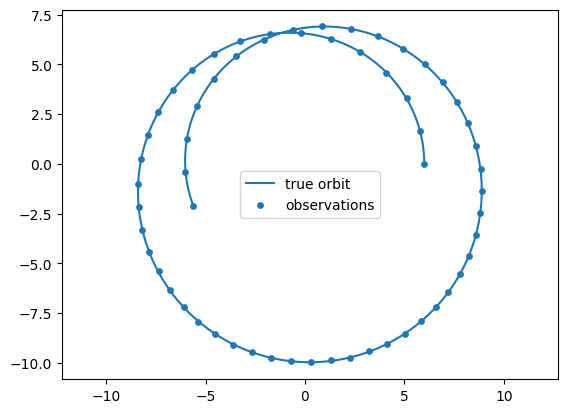

True M, a: 1.0 0.6
r min / max: 6.0 10.0


In [11]:
data = generate_synthetic_orbit()

print('done')

plt.figure()
plt.plot(data.x_true, data.y_true, label="true orbit")
plt.scatter(data.x_obs, data.y_obs, s=15, label="observations")
plt.axis("equal")
plt.legend()
plt.show()

print("True M, a:", data.M_true, data.a_true)
print("r min / max:", data.r_true.min(), data.r_true.max())